# Plotting stuff

In [1]:
### IMPORTS ### 
import sys

from Func_Floquet_classes import *
from matplotlib import cm
from IPython.display import Math
from sympy.interactive import printing

import seaborn as sns
import pandas as pd

## Personalized plots
from matplotlib.lines import Line2D
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r"\usepackage{bm,amsmath,amsfonts,amssymb,bbold}"
from Func_general import *
# plotParams('paper')

plt.rcParams.update({
    "pgf.texsystem": "lualatex",
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
         r"\usepackage{amssymb}",   
         r"\usepackage{unicode-math}",   # unicode math setup
         r"\setromanfont[Scale=1.04]{Libertinus Serif}",  # serif font via preamble
         r"\setsansfont[Scale=1]{Libertinus Sans}",
         r"\setmonofont[Scale=.89]{Liberation Mono}",
         r"\setmathfont{Libertinus Math}"
    ]),
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "serif"
})

def set_size(width, height=None, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height==None:
        fig_height_in = fig_width_in * golden_ratio
    else:
        fig_height_in = height * inches_per_pt

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

textwidth = 304.44289 #pt
pagewidth = 457.8024 #pt
textheight = 689.0 #pt

palette = sns.color_palette("colorblind6")
palette

%matplotlib inline

# Dirac model linear polarization

In [4]:
## Define the Hamiltonian in SymPy form
ham_symbolsLin = sp.symbols("v hbar", real=True) ## definition of the extra symbols, in this case the velocity of the linear term
ham_dict = {str(b): b for b in ham_symbolsLin}
locals().update( ham_dict)

hDirac = Hamiltonian(
    h0_k = hbar* v*sx*k_y - hbar* v*sy*k_x,
    Axt=A_x * sp.sin(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    ham_symbols=ham_symbolsLin)

In [6]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

T = 1
st_dev = np.sqrt(2) * 1.5

par_fix = {'v':1., 'T_p' : 1.,'mu_sp': 3*st_dev, 'tau_sp': st_dev, }
params_env = {'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp)),
    Vyt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp) + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) ## N is the number of Fourier replicas considered.


In [7]:
hDirac_pulse.Axenv

In [8]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 0.0, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -0.1999, wf (spinor): [-0.707+0.j     0.   -0.707j]


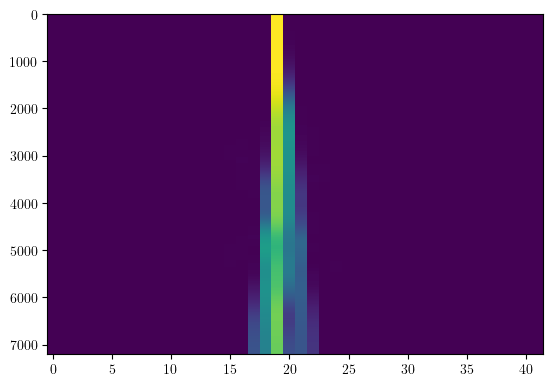

In [37]:
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

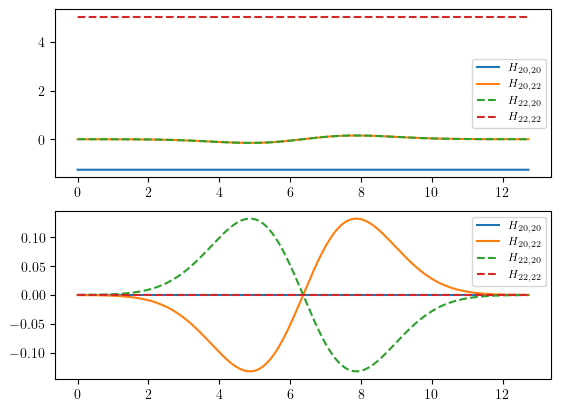

In [12]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

ax = axs[1]
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

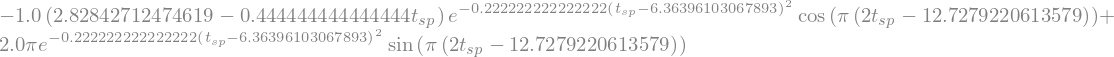

In [10]:
nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hDirac_pulse.Axenv * hDirac_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: par_fix['tau_sp'], mu_sp: par_fix['mu_sp'], A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

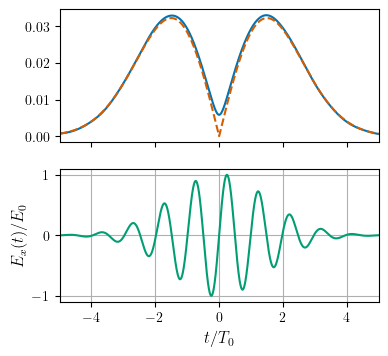

In [13]:
corr = -1.0j*ifs_hamiltonians[:,20,22]/(xis[:,22] - xis[:,20])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,22]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

# Massive model

In [14]:
## Define the Hamiltonian in SymPy form
ham_symbolsLin = sp.symbols("v hbar m", real=True) ## definition of the extra symbols, in this case the velocity of the linear term
ham_dict = {str(b): b for b in ham_symbolsLin}
locals().update( ham_dict)

hDirac = Hamiltonian(
    h0_k = hbar* v*sx*k_y - hbar* v*sy*k_x + m*sz,
    Axt=A_x * sp.sin(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    ham_symbols=ham_symbolsLin)

In [31]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v m mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

T = 1
st_dev = np.sqrt(2) * 1.5

par_fix = {'v':1., 'T_p' : 1.,'mu_sp': 3*st_dev, 'tau_sp': st_dev, 'm': 0.5}
params_env = {'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy) + m*sz,
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp)),
    Vyt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp) + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) ## N is the number of Fourier replicas considered.


In [32]:
hDirac_pulse.Axenv

In [33]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 0.0, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -0.5385, wf (spinor): [-0.189+0.j     0.   -0.982j]


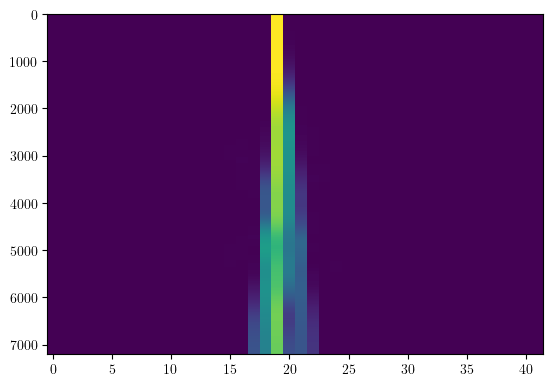

In [ ]:
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

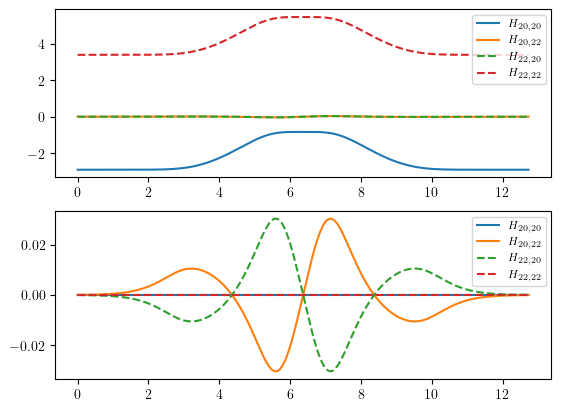

In [34]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

ax = axs[1]
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

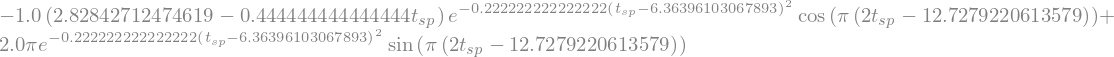

In [35]:
nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hDirac_pulse.Axenv * hDirac_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: par_fix['tau_sp'], mu_sp: par_fix['mu_sp'], A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

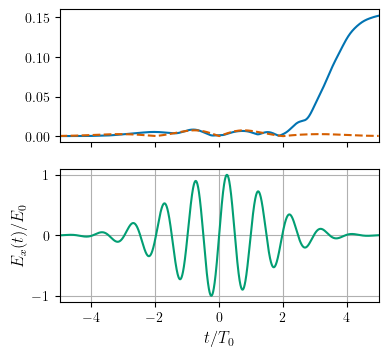

In [36]:
corr = -1.0j*ifs_hamiltonians[:,20,22]/(xis[:,22] - xis[:,20])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,22]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

# TI

In [2]:

## Units conversion
import scipy.constants as sconst

###############################
### Bi2Se3 Hamiltonian:

def calcBi2Se3(paramsBi2Se3):
    pZ = SimpleNamespace(**paramsBi2Se3)
    v0eff = pZ.v0 * pZ.a1
    C0eff, C2eff, R1eff = (pZ.C0 + pZ.a3 * pZ.M0), (pZ.C2 + pZ.a3 * pZ.M2), (0.5 * pZ.R1 * pZ.a1)
    C0eff = 0  # we are setting onsite constant term to 0
    pB = dict(**paramsBi2Se3, C0eff=C0eff, C2eff=C2eff, R1eff=R1eff, v0eff=v0eff)
    return pB

paramsBi2Se3 = calcBi2Se3({'C0': -0.0083, 'C2': 30.4, 'M0': -0.28, 'M2': 44.5, 'v0': 3.33,
                           'R1': 50.6, 'a1': 0.99, 'a3': -0.15})  # in units of eV and Angstrom

omega_eV = 0.160 #eV
paramsPulse = dict(adim=1 / omega_eV,  polar='linearx', theta=0)
pB = SimpleNamespace(**paramsBi2Se3, **paramsPulse)

hbar_eVs = sconst.physical_constants['reduced Planck constant in eV s'][0]
t_THZ = omega_eV/(2*np.pi*hbar_eVs)*1e-12


In [3]:
## Define the Floquet t-t' Hamiltonian

st_dev = np.sqrt(2) * 1.5
par_fix = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p' : 1.,
           'mu_sp': 3*st_dev, 'tau_sp': st_dev}
params_env = {'A_x': 0.15, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : 0.1, 'k_y' : 0.0}

ham_symbols = sp.symbols("W C_0 C_2 v_0 R_1 mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hBi2Se3_pulse = Hamiltonian_ttp(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                     + v_0 * (k_y * sx - k_x * sy) + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 50) #Importat: add N large!

## Quantities for adim 
A0 = 1./(pB.v0eff*par_fix['W'])
kprop = pB.v0eff*par_fix['W']

In [13]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': A0*4, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 2000) + 1e-6
params_ham = {'k_x': 0.02, 'k_y': 0.0, }
solver = (IFS_solver(hBi2Se3_pulse, ts3, params_env, params_ham, Nmax=15))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

State at t = 0.00 energy = -0.3528, wf (spinor): [-0.705+0.j     0.   -0.709j]


## Load data

In [4]:
## Units conversion
import scipy.constants as sconst

###############################
### Bi2Se3 Hamiltonian:

def calcBi2Se3(paramsBi2Se3):
    pZ = SimpleNamespace(**paramsBi2Se3)
    v0eff = pZ.v0 * pZ.a1
    C0eff, C2eff, R1eff = (pZ.C0 + pZ.a3 * pZ.M0), (pZ.C2 + pZ.a3 * pZ.M2), (0.5 * pZ.R1 * pZ.a1)
    C0eff = 0  # we are setting onsite constant term to 0
    pB = dict(**paramsBi2Se3, C0eff=C0eff, C2eff=C2eff, R1eff=R1eff, v0eff=v0eff)
    return pB

paramsBi2Se3 = calcBi2Se3({'C0': -0.0083, 'C2': 30.4, 'M0': -0.28, 'M2': 44.5, 'v0': 3.33,
                           'R1': 50.6, 'a1': 0.99, 'a3': -0.15})  # in units of eV and Angstrom

omega_eV = 0.160 #eV
paramsPulse = dict(adim=1 / omega_eV,  polar='linearx', theta=0)
pB = SimpleNamespace(**paramsBi2Se3, **paramsPulse)
tau = np.sqrt(2) * 1.5

hbar_eVs = sconst.physical_constants['reduced Planck constant in eV s'][0]
t_THZ = omega_eV/(2*np.pi*hbar_eVs)*1e-12

## Define the Floquet t-t' Hamiltonian

par_fix = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p' : 1.}
params_env = {'mu_sp' : 3*tau, 'tau_sp' : tau, 'A_x': 0.15, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : 0.1, 'k_y' : 0.0}

ham_symbols = sp.symbols("W C_0 C_2 v_0 R_1 mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hBi2Se3_pulse = Hamiltonian_ttp(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                     + v_0 * (k_y * sx - k_x * sy) + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 50) #Importat: add N large!

## Quantities for adim 
A0 = 1./(pB.v0eff*par_fix['W'])
kprop = pB.v0eff*par_fix['W']

psi0band, T = 0, 1.
ks = np.linspace(-0.1, 0.1, 64) + 1e-6
ts = np.linspace(0, 2.0 * 3.0 * tau * T, 8000) + 1e-6


In [8]:
# path = "/home/how09898/phd/thesis-figures-data/floquet-sidebands/data-bise/fig_Bi2Se3Lin_calphaData_sin.npy"
path = "/home/how09898/phd/thesis-figures-data/floquet-sidebands/data-bise/fig_Bi2Se3Lin_calphaData_conv_N_60_sin.npy"
data = np.load(path, allow_pickle=True)


In [9]:
print(f"{len(data)} k_x points.")
data[22]['k_x']

64 k_x points.


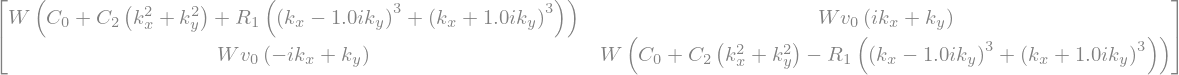

In [13]:
hBi2Se3_pulse.h0_k

In [18]:
h0_lambd = sp.lambdify([k_x,k_y],
                       hBi2Se3_pulse.h0_k.evalf(subs={hBi2Se3_pulse.ham_dict[key]: val for key, val in par_fix.items()}))

## Fermi level

kF at kx = 0.0625428060200669


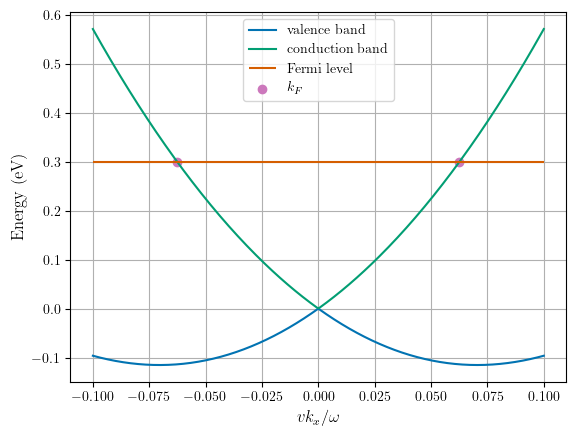

In [38]:
ks =np.linspace(-0.1, 0.1, 300) + 1e-6

vb = np.array([omega_eV* np.linalg.eigvalsh(h0_lambd(k,0))[0] for k in ks])
cb = np.array([omega_eV* np.linalg.eigvalsh(h0_lambd(k,0))[1] for k in ks])

# simple brute-force finding of kx max
ikmax = np.argmin(np.abs(cb - 0.3))
kF    = ks[ikmax]
print(f"kF at kx = {kF}")

plt.plot(ks, vb, label="valence band", color=palette[0])
plt.plot(ks, cb, label="conduction band", color=palette[1])
plt.ylabel("Energy (eV)")
plt.xlabel(r"$v k_x/\omega$")
plt.hlines(0.3, ks[0], ks[-1], color=palette[2], label="Fermi level")
plt.scatter(kF, cb[ikmax], color=palette[3], label=r"$k_F$")
plt.scatter(-kF, cb[ikmax], color=palette[3])
plt.legend()
plt.grid()

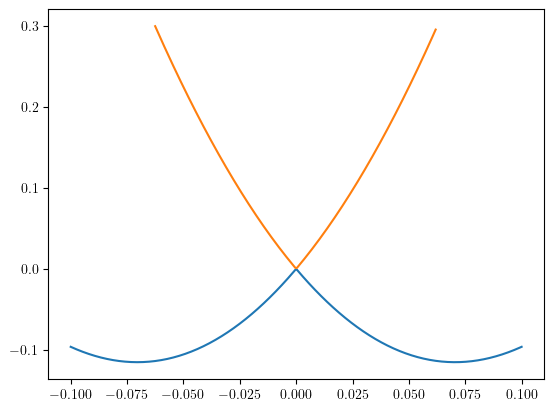

In [43]:
plt.plot(ks, vb)
plt.plot( ks[np.where(np.abs(ks) < kF)], cb[np.where(np.abs(ks) < kF)])

## Time-dependent occupation over spectra

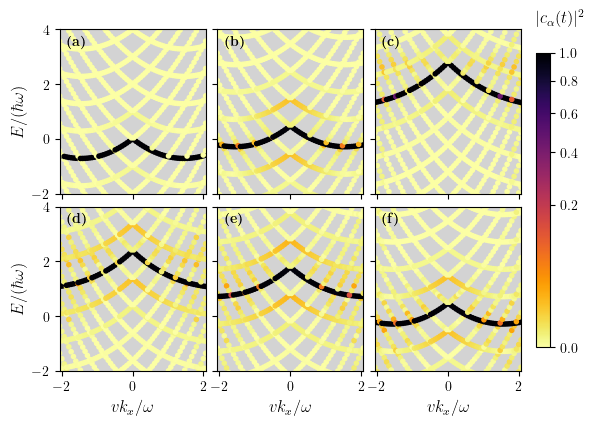

In [12]:
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=set_size(pagewidth, 0.7*pagewidth), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

t_sel = np.array([-4, -2, 0, 0.6, 1 , 2])+3*tau
inds_t = [np.argmin(np.abs(ts-ti)) for ti in t_sel]

cmap = mpl.colormaps['inferno_r']
# cmap = sns.color_palette("flare", as_cmap=True)
norm = mpl.colors.PowerNorm(vmin=0, vmax=1, gamma=0.45)

for ti, ax in zip(inds_t, axs.ravel()):
    eL = np.array([datai['eL'][ti] for datai in data])
    ct_k = np.array([datai['ct'] for datai in data])
    indexCbase_k = np.array([datai['indexCbase'] for datai in data])
    col_k = np.abs(ct_k[:,ti]) ** 2
    ensL = np.array([eL[ki, indexCbase_k[ki]] for ki in range(len(ks))])
    for nband in range(len(indexCbase_k[0])):
        z1 = ax.scatter(ks*kprop, ensL[:,nband], c=col_k[:,nband], s=9, cmap=cmap, norm=norm, zorder = nband-50)
    ax.set(facecolor='lightgrey')
[ax.set(ylabel=r'$E/(\hbar \omega)$', ylim=(-2, 4), xlim=(-0.1*kprop, 0.1*kprop)) for ax in axs[:,0]]
# [ax.set(ylabel=r'$E/(\hbar \omega)$', ylim=(-2, 4), xlim=(-0.07*kprop, 0.07*kprop)) for ax in axs[:,0]]
[ax.set(xlabel=(r'$vk_x/\omega$')) for ax in axs[1]]
cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap,  norm = norm), 
                       ax=axs, pad=0.03, shrink=0.95, aspect=20, fraction=0.03)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=12, y=1.15, pad=-10, loc='left')
# cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap,  norm = norm), ax=axs)
# cbar_ax.set_label('bla', fontsize=12)
createletters(axs.ravel(), coord=[0.05, 0.9], SMALL_SIZE=10)
fig.savefig("/home/how09898/phd/thesis-figures-data/floquet-sidebands/fig_Bi2Se3Lin_calphaData_sin.pdf", backend='pgf', bbox_inches='tight')

## Adiabatic corrections for smaller k

k_x = -0.3597


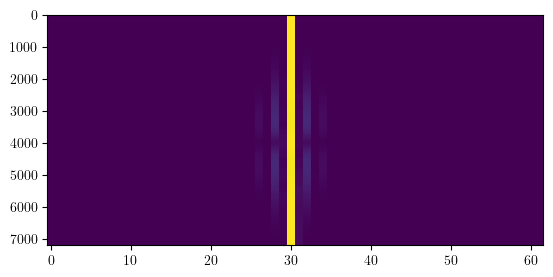

In [48]:
ik = 26
print(f"k_x = {data[ik]['k_x']*kprop:.4f}")

ct = data[26]['ct']
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

In [49]:
ifs_hamiltonians = data[ik]['hamiltonian']

nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hBi2Se3_pulse.Axenv * hBi2Se3_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: tau, mu_sp:  3*tau, A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

                                                                              
                                                   -9.0⋅(0.157134840263677⋅tₛₚ
- 0.15⋅(2.82842712474619 - 0.444444444444444⋅tₛₚ)⋅ℯ                           

     2                                                       2             
 - 1)                        -9.0⋅(0.157134840263677⋅tₛₚ - 1)              
      ⋅sin(2⋅π⋅tₛₚ) - 0.3⋅π⋅ℯ                                 ⋅cos(2⋅π⋅tₛₚ)

(-5.0, 5.0)

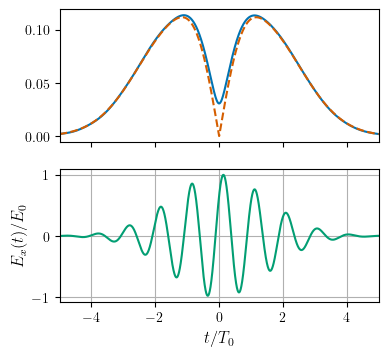

In [50]:
j_in = 30
j_shift = -2
ts = data[ik]["ts"]
ts_ct = data[ik]["ts_ct"]

corr = -1.0j*ifs_hamiltonians[:,j_in,j_in-j_shift]/(xis[:,j_in] - xis[:,j_in+j_shift])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts_ct-3*tau, np.abs(ct[:,j_in+j_shift]), color=palette[0])
ax.plot(ts[:-1]-3*tau,np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts_ct-3*tau,ext_full(ts_ct)/np.max(ext_full(ts_ct)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

## LZ transitions for larger k

k_x = 1.6026


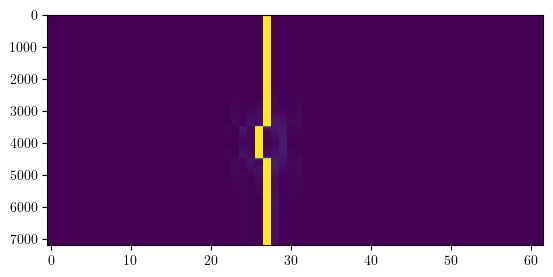

In [44]:
ik = 56
print(f"k_x = {data[ik]['k_x']*kprop:.4f}")

ct = data[ik]['ct']
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

In [45]:
ifs_hamiltonians = data[ik]['hamiltonian']

nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hBi2Se3_pulse.Axenv * hBi2Se3_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: tau, mu_sp:  3*tau, A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

                                                                              
                                                   -9.0⋅(0.157134840263677⋅tₛₚ
- 0.15⋅(2.82842712474619 - 0.444444444444444⋅tₛₚ)⋅ℯ                           

     2                                                       2             
 - 1)                        -9.0⋅(0.157134840263677⋅tₛₚ - 1)              
      ⋅sin(2⋅π⋅tₛₚ) - 0.3⋅π⋅ℯ                                 ⋅cos(2⋅π⋅tₛₚ)

(-5.0, 5.0)

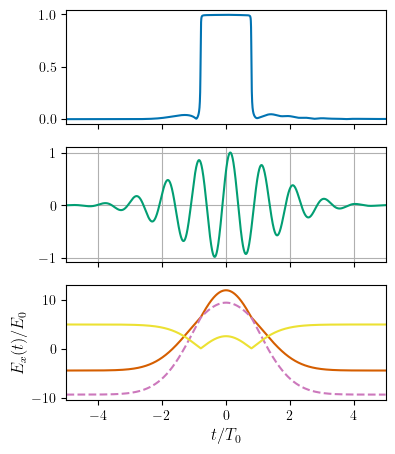

In [47]:
j_in = 27
j_shift = -1

ts = data[ik]["ts"]
ts_ct = data[ik]["ts_ct"]

corr = -1.0j*ifs_hamiltonians[:,j_in,j_in-j_shift]/(xis[:,j_in] - xis[:,j_in+j_shift])

fig, axs = plt.subplots(3,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.8*pagewidth))

ax = axs[0]
ax.plot(ts_ct-3*tau, np.abs(ct[:,j_in+j_shift]), color=palette[0])
# ax.plot(ts[:-1]-3*tau,np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts_ct-3*tau,ext_full(ts_ct)/np.max(ext_full(ts_ct)), color=palette[1])
ax.grid()

ax = axs[2]
ax.plot(ts[:-1]-3*tau,xis[:,j_in], '-', color=palette[2])
ax.plot(ts[:-1]-3*tau,xis[:,j_in+j_shift], '--', color=palette[3])
ax.plot(ts[:-1]-3*tau,np.abs(xis[:,j_in]-xis[:,j_in+j_shift]), '-', color=palette[4])
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)